In [106]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [107]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [108]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [109]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [110]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9872,1697472000,1.05414,1.05436,1.05351,1.05375,4272,9,0
9873,1697473800,1.05374,1.05384,1.05277,1.05295,5124,9,0
9874,1697475600,1.05295,1.05399,1.05252,1.05390,4745,9,0
9875,1697477400,1.05390,1.05551,1.05384,1.05493,5198,9,0


In [111]:


def calculateSuperTrendIndicator(df, multiplier = 2, atrLookup = 10):
    supertrend= ta.supertrend(df['high'], df['low'], df['close'], length=atrLookup, multiplier=multiplier)
    df['supertrend'] = supertrend[f'SUPERT_{atrLookup}_{float(multiplier)}']
    return df





In [112]:
multiplier = 2
atrLookup = 20


df = calculateSuperTrendIndicator(df, multiplier, atrLookup)

df = df[atrLookup:]
df = df.dropna()
df


,time,open,high,low,close,tick_volume,spread,real_volume,supertrend
20,1672653600,1.06783,1.06799,1.06708,1.06757,3068,7,0,1.065156
21,1672655400,1.06757,1.06964,1.06744,1.06785,3782,7,0,1.066008
22,1672657200,1.06785,1.06992,1.06783,1.06831,5641,7,0,1.066221
23,1672659000,1.06833,1.06843,1.06765,1.06782,3401,8,0,1.066221
24,1672660800,1.06787,1.06895,1.06769,1.06819,1905,7,0,1.066221
...,...,...,...,...,...,...,...,...,...
9872,1697472000,1.05414,1.05436,1.05351,1.05375,4272,9,0,1.052401
9873,1697473800,1.05374,1.05384,1.05277,1.05295,5124,9,0,1.052401
9874,1697475600,1.05295,1.05399,1.05252,1.05390,4745,9,0,1.052401
9875,1697477400,1.05390,1.05551,1.05384,1.05493,5198,9,0,1.052852


In [113]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 1.5 / 100

slamount = None
tpamount = None

for i in range(len(df)):
    if (i > 0) and (df.iloc[i]['close'] > df.iloc[i]['supertrend']) and (df.iloc[i - 1]['close'] < df.iloc[i]['supertrend']):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['close'] < df.iloc[i]['supertrend']) and
            (df.iloc[i - 1]['close'] > df.iloc[i]['supertrend'])
        ) or (
            df.iloc[i]['close'] <= slamount
        ) or (
            df.iloc[i]['close'] >= tpamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None
    

In [114]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.05813, 1.06837, 1.08515, 1.09635, 1.10003, 1.07175, 1.10576, 1.08454]
[1.0745, 1.06266, 1.0786, 1.09299, 1.08099, 1.1226, 1.07861]
[206, 2380, 2758, 3467, 4427, 5294, 6587, 8222]
[254, 2503, 2834, 4463, 5638, 6649, 8369]


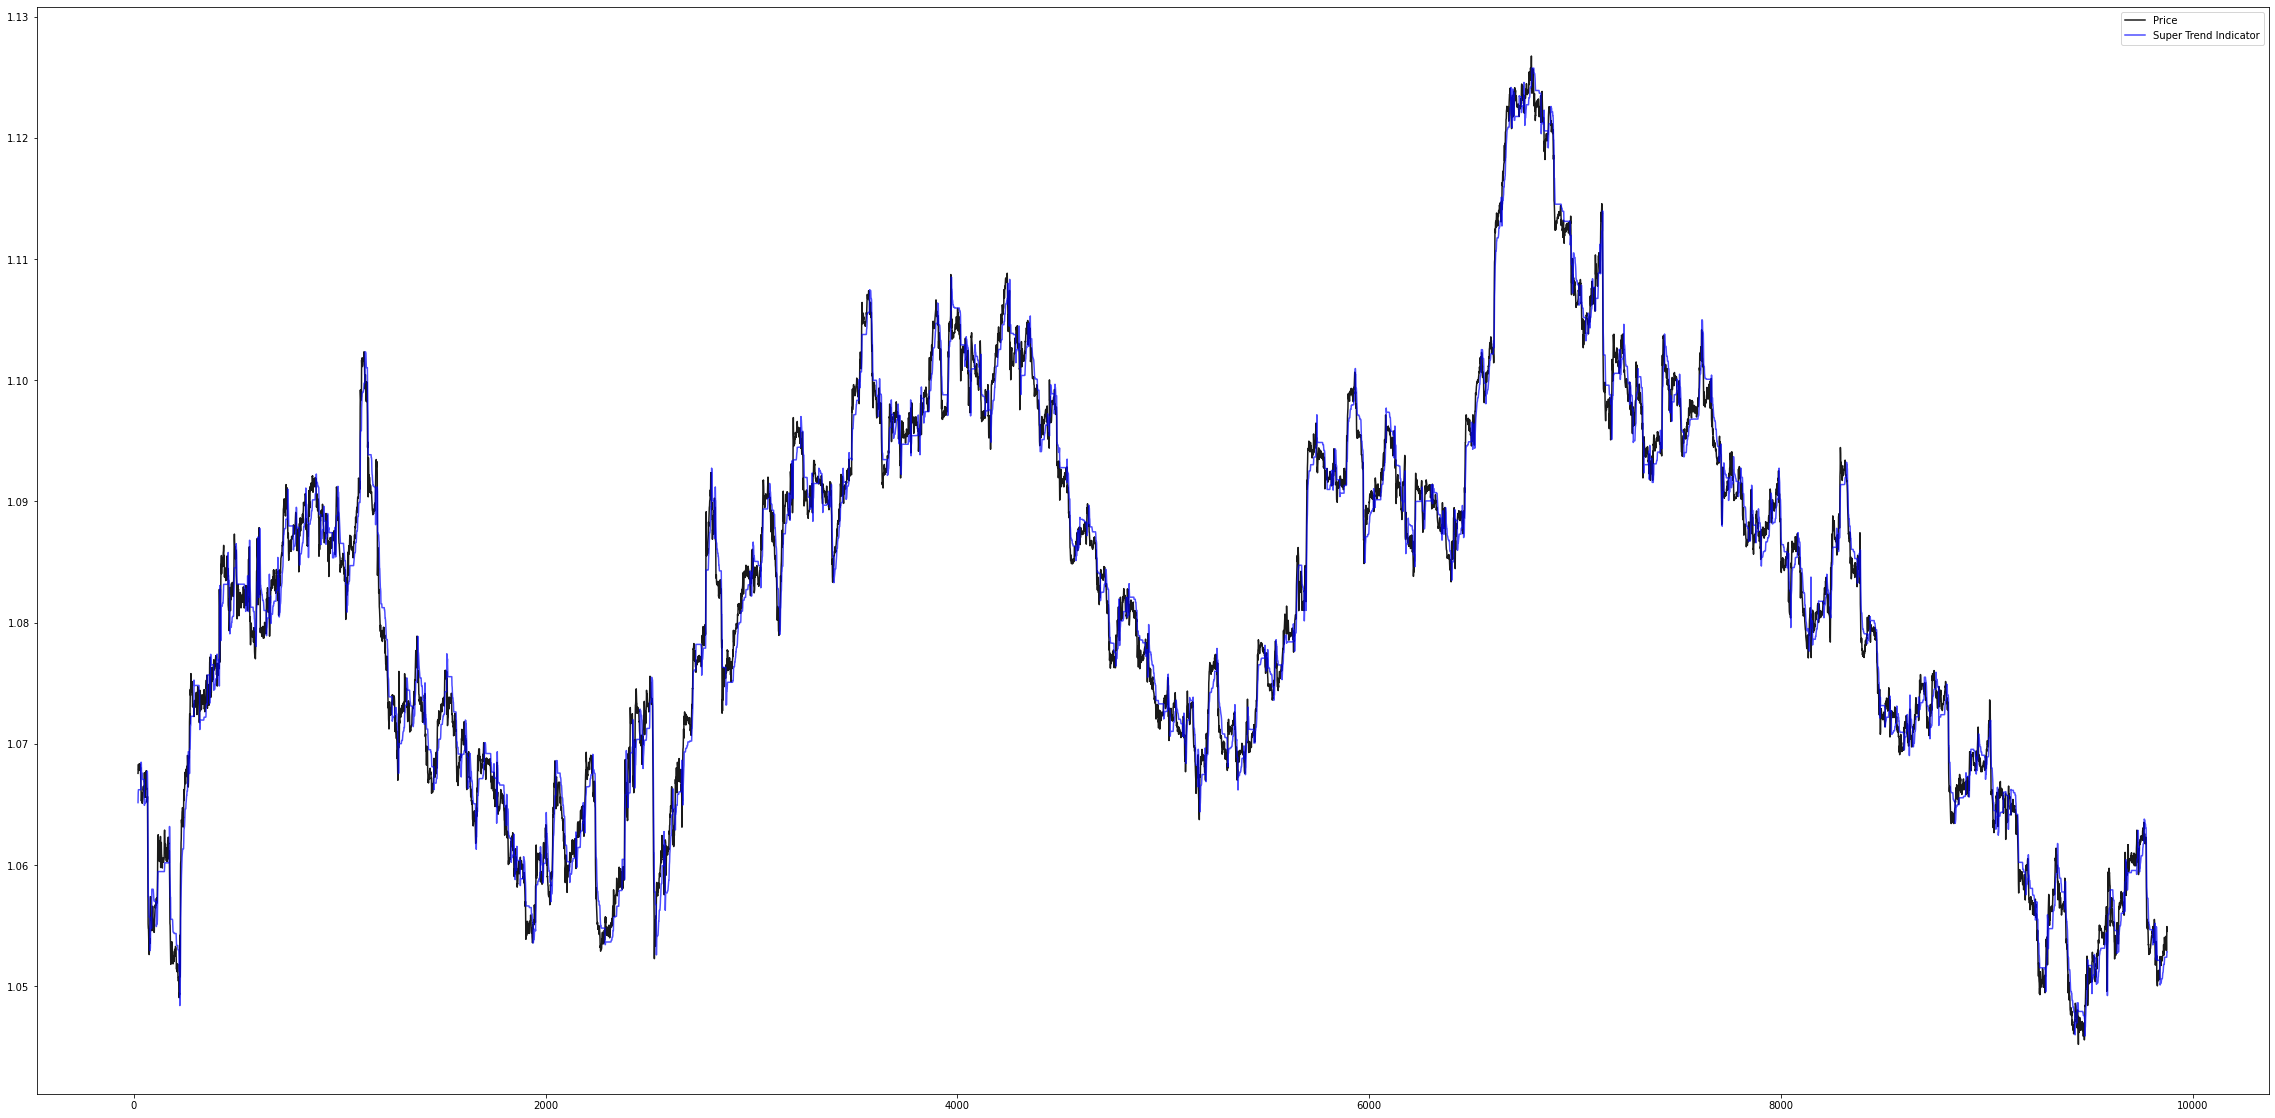

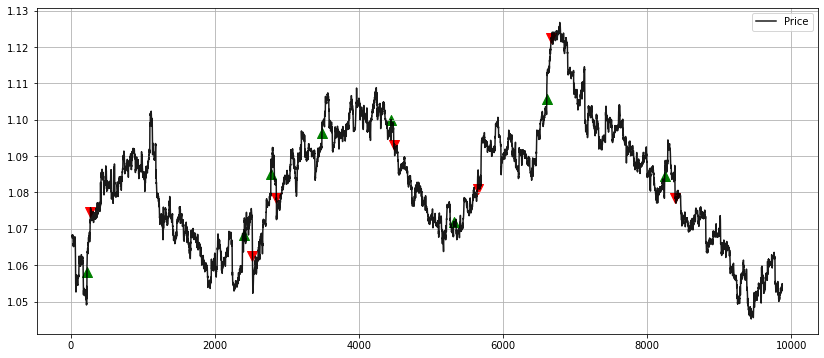

In [115]:


plt.figure(figsize = (40, 20))
plt.plot(df['close'], label='Price', c='black', alpha=0.9)
plt.plot(df['supertrend'], label='Super Trend Indicator', c='blue', alpha=0.7)
plt.legend()
plt.show()
     

plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



In [116]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

averageprofit = profit / wins
averageloss = loss / losses
hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 28.57142857142857 %
    Profit factor = 0.38884869025991914 {currency}
    Expectancy = 1.2880929657142883 {currency}
    Realised risk reward ratio = 0.9721217256497978 {currency}

